In [17]:
# import libs

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

# define path
path = 'C:/Users/phili/Documents/DTU/Projects/Digit Recognition/input/'

# test if GPU is detected
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



True
Num GPUs Available:  1


In [18]:
# import data
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [19]:
X = train.drop(['label'], 1).values
y = train['label'].values

# normalistation
X = X / 255.0
# reshape
X = X.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


C:\Users\phili\AppData\Local\Temp\ipykernel_24596\1742482822.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


In [20]:
# split into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

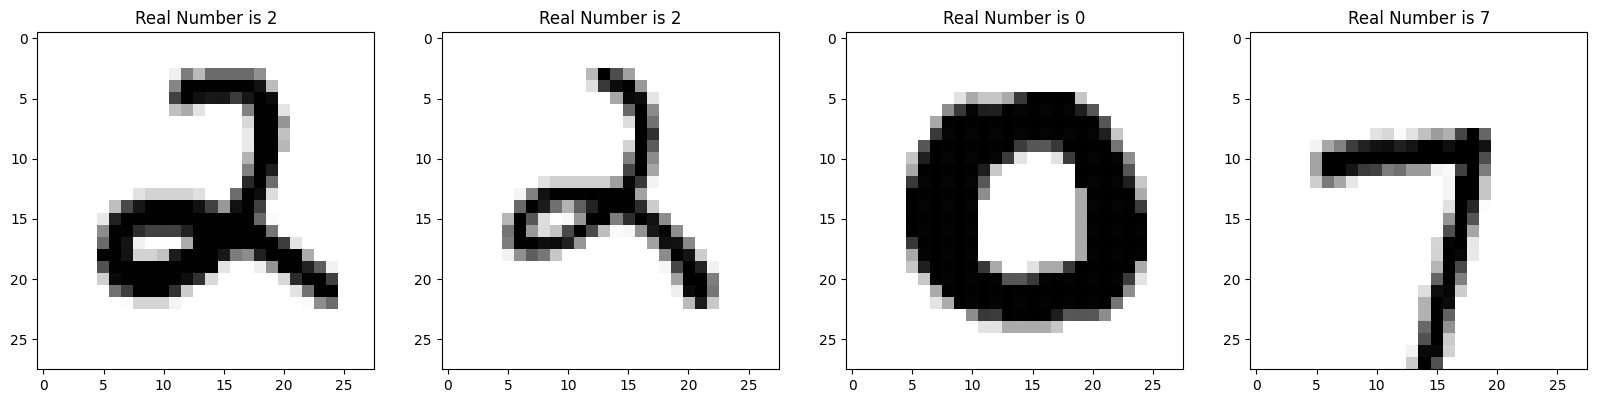

In [21]:
# data visualisation

X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [22]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [23]:
# define model

model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

In [25]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [26]:
# define variables

epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [27]:
# fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks= [es, rp])

Epoch 1/100


C:\Users\phili\AppData\Local\Temp\ipykernel_24596\2475320829.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


295/295 [==============================] - 7s 21ms/step - loss: 0.1613 - accuracy: 0.9500 - val_loss: 1.7737 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/100
295/295 [==============================] - 6s 19ms/step - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.0782 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 3/100
295/295 [==============================] - 6s 19ms/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 0.0557 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 4/100
295/295 [==============================] - 6s 19ms/step - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0435 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 5/100
295/295 [==============================] - 6s 19ms/step - loss: 0.0396 - accuracy: 0.9873 - val_loss: 0.0645 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 6/100
295/295 [==============================] - 6s 19ms/step - loss: 0.0352 - accuracy: 0.9894 - val_loss: 0.0631 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 7/100
293/295 [============================>.] - ETA: 0s - loss:

In [28]:
model.save('modelv2.h5')

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


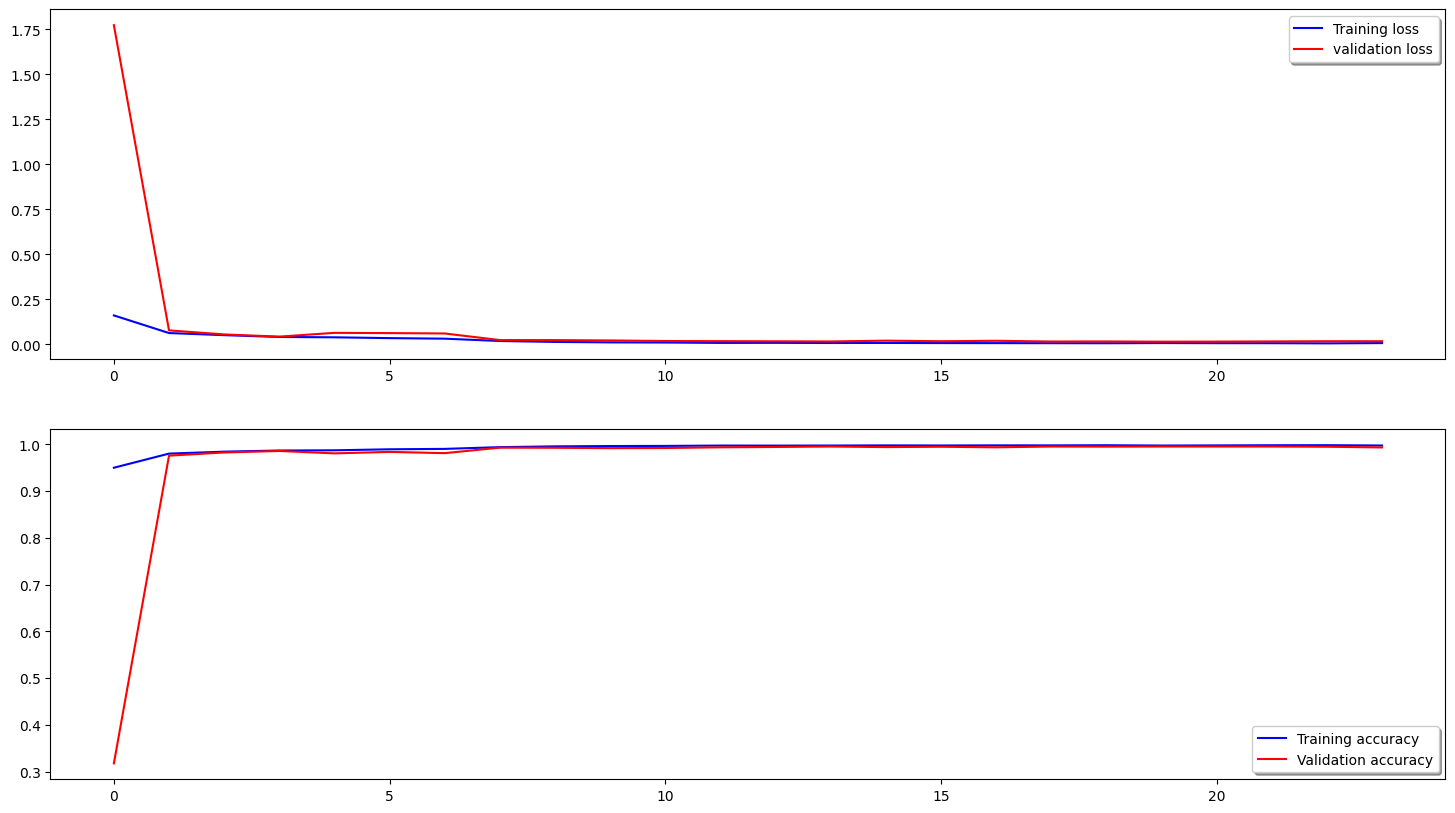

In [30]:
# evaluate model
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 0s 1ms/step


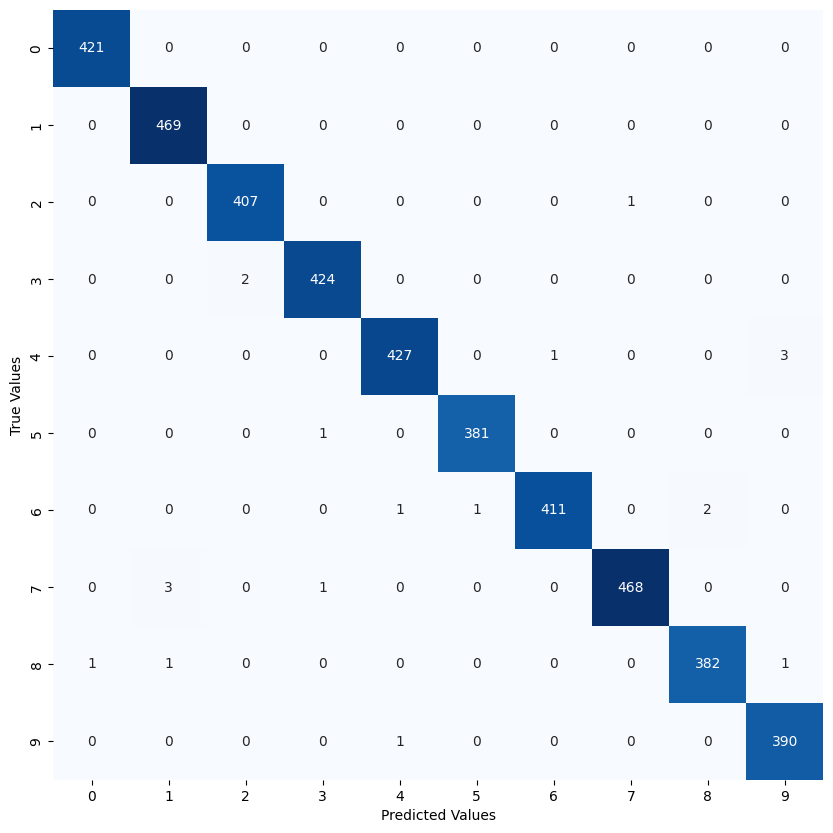

In [31]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

132/132 [==============================] - 0s 1ms/step


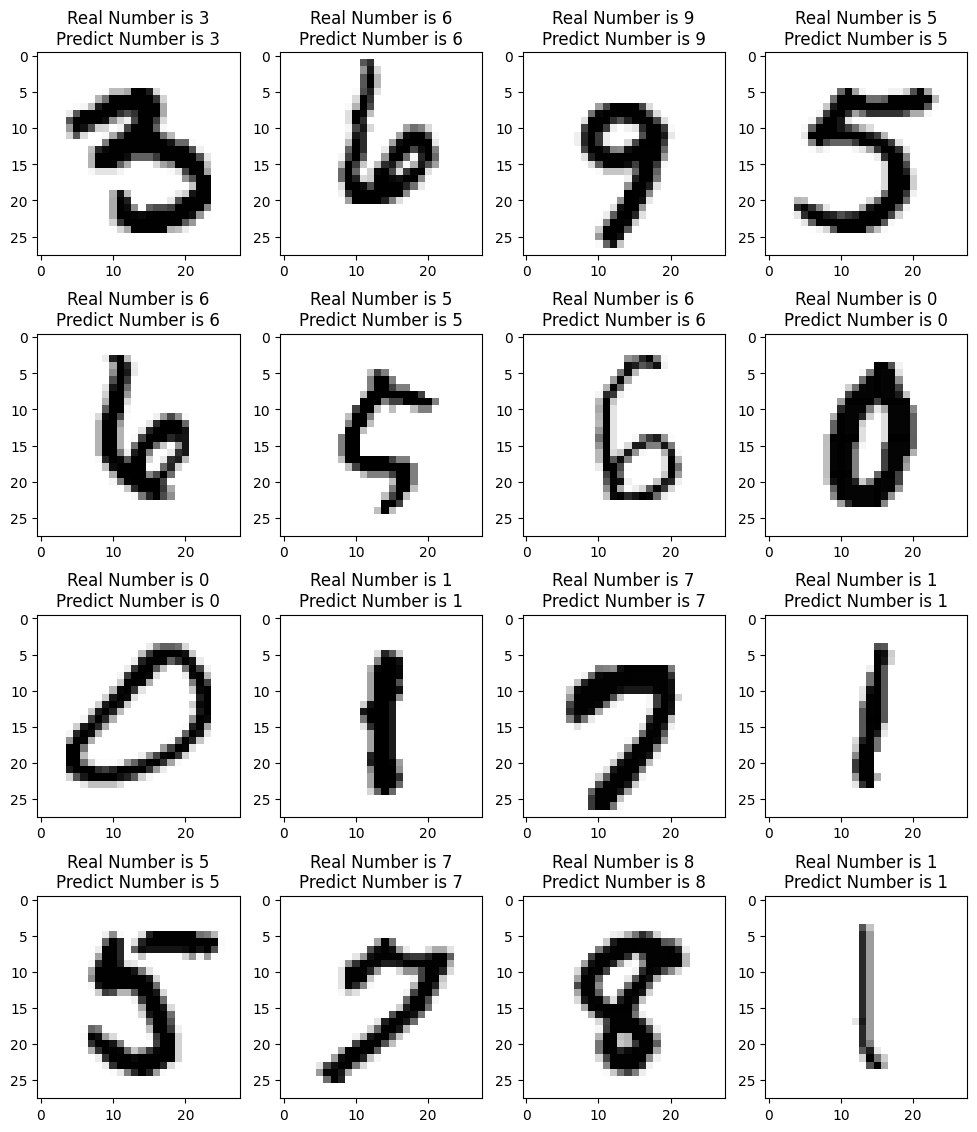

In [32]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");